In [1]:
%config Completer.use_jedi = False

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import (make_scorer,
                             accuracy_score,
                             classification_report,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score,
                             auc,
                             roc_auc_score,
                             roc_curve,
                             precision_recall_curve,
                             average_precision_score
                            )
from sklearn.feature_selection import SelectFromModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import os

# Load and prepare data

In [2]:
td_props = pd.read_csv('../data/filtered_template_based_docking_w_descriptors.csv')
td_props = td_props.dropna().reset_index(drop=True)

# td_props = td_props.drop(columns=["MCS_SMARTS_Atoms_wildcards", "MCS_SMARTS_Bonds_wildcards"])

td_props.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 53 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   UniProt_ID                         13611 non-null  object 
 1   Template                           13611 non-null  object 
 2   Docked                             13611 non-null  object 
 3   Pose                               13611 non-null  int64  
 4   hyde_rmsd                          13611 non-null  float64
 5   Cluster_ID                         13611 non-null  int64  
 6   cluster_mcs                        13611 non-null  object 
 7   Label                              13611 non-null  int64  
 8   MCS                                13611 non-null  object 
 9   Template_HeavyAtomCount            13611 non-null  float64
 10  Template_LogP                      13611 non-null  float64
 11  Template_TPSA                      13611 non-null  flo

In [3]:
td_props = td_props.rename(columns={'Label': 'label'})

In [4]:
td_props.columns

Index(['UniProt_ID', 'Template', 'Docked', 'Pose', 'hyde_rmsd', 'Cluster_ID',
       'cluster_mcs', 'label', 'MCS', 'Template_HeavyAtomCount',
       'Template_LogP', 'Template_TPSA', 'Template_NHOHCount',
       'Template_NOCount', 'Template_NumHAcceptors', 'Template_NumHDonors',
       'Template_NumHeteroAtoms', 'Template_NumRotatableBonds',
       'Template_RingSystemsCount', 'Template_RingCount',
       'Template_NumAliphaticRings', 'Template_NumAromaticRings',
       'Template_NumAliphaticHeterocycles', 'Template_NumAromaticHeterocycles',
       'Docked_HeavyAtomCount', 'Docked_LogP', 'Docked_TPSA',
       'Docked_NHOHCount', 'Docked_NOCount', 'Docked_NumHAcceptors',
       'Docked_NumHDonors', 'Docked_NumHeteroAtoms',
       'Docked_NumRotatableBonds', 'Docked_RingSystemsCount',
       'Docked_RingCount', 'Docked_NumAliphaticRings',
       'Docked_NumAromaticRings', 'Docked_NumAliphaticHeterocycles',
       'Docked_NumAromaticHeterocycles', 'Template_MCS_HeavyAtomRatio',
       '

In [5]:
feature_cols = ['Template_HeavyAtomCount', 'Template_LogP', 'Template_TPSA', 'Template_NHOHCount',
                'Template_NOCount', 'Template_NumHAcceptors', 'Template_NumHDonors',
                'Template_NumHeteroAtoms', 'Template_NumRotatableBonds',
                'Template_RingSystemsCount', 'Template_RingCount',
                'Template_NumAliphaticRings', 'Template_NumAromaticRings',
                'Template_NumAliphaticHeterocycles', 'Template_NumAromaticHeterocycles',
                'Docked_HeavyAtomCount', 'Docked_LogP', 'Docked_TPSA',
                'Docked_NHOHCount', 'Docked_NOCount', 'Docked_NumHAcceptors',
                'Docked_NumHDonors', 'Docked_NumHeteroAtoms',
                'Docked_NumRotatableBonds', 'Docked_RingSystemsCount',
                'Docked_RingCount', 'Docked_NumAliphaticRings',
                'Docked_NumAromaticRings', 'Docked_NumAliphaticHeterocycles',
                'Docked_NumAromaticHeterocycles', 'Template_MCS_HeavyAtomRatio',
                'Template_MCS_NHOH_Atoms', 'Template_MCS_NO_Atoms',
                'Template_MCS_H_Acceptors', 'Template_MCS_H_Donors',
                'Docked_MCS_HeavyAtomRatio', 'Docked_MCS_NHOH_Atoms',
                'Docked_MCS_NO_Atoms', 'Docked_MCS_H_Acceptors', 'Docked_MCS_H_Donors', 'ECTS']

In [6]:
len(feature_cols)

41

In [7]:
td_props_clean = td_props[['UniProt_ID', 'Template', 'Docked', 'Pose', 'hyde_rmsd']]
td_props_clean

,UniProt_ID,Template,Docked,Pose,hyde_rmsd
0,O14757,3OT3_22K,3OT8_MI5,7,1.483
1,O14757,3OT8_MI5,3OT3_22K,4,0.952
2,O14757,2BR1_PFP,2BRH_DFW,9,1.222
3,O14757,2BR1_PFP,2CGX_3D3,5,4.837
4,O14757,2BRB_PFQ,2CGX_3D3,8,6.664
...,...,...,...,...,...
13606,Q54276,1W1Y_TYP,1W1V_ALJ,10,1.034
13607,Q8I3X4,1NW4_IMH,1Q1G_MTI,3,0.749
13608,Q8I3X4,1NW4_IMH,6AQS_IM5,3,2.000
13609,Q8I3X4,6AQS_IM5,1Q1G_MTI,6,1.270


In [8]:
simmat = pd.read_csv('../../final_astex/docking_results/similarity_matrix.csv')
simmat.index = simmat.columns

Split data randomly, mantaining target information for later analysis

In [9]:
train_df, test_df = train_test_split(td_props, test_size=0.2, random_state=42)

# Keep groups separate for analysis later
groups_train = train_df['UniProt_ID'].reset_index(drop=True)
groups_test = test_df['UniProt_ID'].reset_index(drop=True)

# Prepare training features and labels (drop group)
X_train = train_df[feature_cols].reset_index(drop=True)
y_train = train_df['label'].reset_index(drop=True)

X_test = test_df[feature_cols].reset_index(drop=True)
y_test = test_df['label'].reset_index(drop=True)


In [10]:
test_df.groupby('label').size()

label
0    1403
1    1320
dtype: int64

In [11]:
X_train

,Template_HeavyAtomCount,Template_LogP,Template_TPSA,Template_NHOHCount,Template_NOCount,Template_NumHAcceptors,Template_NumHDonors,Template_NumHeteroAtoms,Template_NumRotatableBonds,Template_RingSystemsCount,...,Template_MCS_NHOH_Atoms,Template_MCS_NO_Atoms,Template_MCS_H_Acceptors,Template_MCS_H_Donors,Docked_MCS_HeavyAtomRatio,Docked_MCS_NHOH_Atoms,Docked_MCS_NO_Atoms,Docked_MCS_H_Acceptors,Docked_MCS_H_Donors,ECTS
0,22.0,3.04852,50.94,3.0,3.0,3.0,2.0,4.0,7.0,2.0,...,1.0,2.0,2.0,1.0,0.652174,1.0,2.0,2.0,1.0,0.396552
1,27.0,2.50952,99.08,5.0,6.0,6.0,3.0,6.0,9.0,3.0,...,1.0,2.0,2.0,1.0,0.689655,1.0,2.0,2.0,1.0,0.550725
2,24.0,3.58112,50.94,3.0,3.0,3.0,2.0,4.0,6.0,3.0,...,2.0,3.0,3.0,2.0,0.923077,2.0,3.0,3.0,2.0,0.467742
3,27.0,2.09072,72.20,4.0,5.0,5.0,3.0,6.0,9.0,3.0,...,2.0,3.0,3.0,2.0,0.538462,2.0,3.0,3.0,2.0,0.486486
4,30.0,0.61060,92.23,4.0,6.0,3.0,2.0,7.0,4.0,3.0,...,2.0,4.0,1.0,2.0,0.696970,3.0,4.0,1.0,3.0,0.208791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10883,41.0,3.72640,166.78,4.0,11.0,9.0,3.0,13.0,11.0,3.0,...,1.0,4.0,4.0,1.0,0.700000,2.0,4.0,3.0,2.0,0.231481
10884,33.0,4.06430,101.05,2.0,7.0,6.0,2.0,8.0,5.0,3.0,...,2.0,5.0,4.0,2.0,0.838710,2.0,5.0,4.0,2.0,0.432432
10885,27.0,3.78022,87.05,4.0,5.0,5.0,2.0,5.0,3.0,3.0,...,2.0,5.0,5.0,2.0,0.869565,2.0,5.0,5.0,2.0,0.348485
10886,31.0,0.21157,154.40,7.0,9.0,5.0,5.0,9.0,9.0,3.0,...,4.0,7.0,4.0,4.0,0.961538,4.0,7.0,4.0,4.0,0.585714


In [12]:
print(f'Dataset: {len(td_props)}')
print(f'Training: {len(X_train)}')
print(f'Testing: {len(X_test)}\n')

print("Train target label distribution:")
print(train_df['label'].value_counts(normalize=True).round(2))

print("\nTest target distribution:")
print(test_df['label'].value_counts(normalize=True).round(2))

Dataset: 13611
Training: 10888
Testing: 2723

Train target label distribution:
label
0    0.52
1    0.48
Name: proportion, dtype: float64

Test target distribution:
label
0    0.52
1    0.48
Name: proportion, dtype: float64


# Models training

Train a Dummy classifier to establish a performace baseline and a simple Logistic regression with default settings to verify that the simplest model can actually learn something

In [13]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(X_test)
print("Dummy Classifier Report:\n", classification_report(y_test, y_dummy_pred, zero_division=0))

# Baseline 2: Basic Logistic Regression (no class_weight, no tuning)
baseline_logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
baseline_logreg.fit(X_train, y_train)
y_baseline_pred = baseline_logreg.predict(X_test)
print("Baseline Logistic Regression Report:\n", classification_report(y_test, y_baseline_pred))

Dummy Classifier Report:
               precision    recall  f1-score   support

           0       0.52      1.00      0.68      1403
           1       0.00      0.00      0.00      1320

    accuracy                           0.52      2723
   macro avg       0.26      0.50      0.34      2723
weighted avg       0.27      0.52      0.35      2723

Baseline Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.67      0.72      0.70      1403
           1       0.68      0.63      0.65      1320

    accuracy                           0.68      2723
   macro avg       0.68      0.68      0.68      2723
weighted avg       0.68      0.68      0.68      2723



Prepare for GridSearchCV for Hyperparameters tuning

In [14]:
models = {
    'LinearSVC': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LinearSVC(random_state=42, max_iter=10000))
        ]),
        'params': {
            'clf__C': [0.01, 0.1, 1, 10, 100]
        }
    },
    'LogisticRegression': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(max_iter=10000, random_state=42))
        ]),
        'params': {
            'clf__C': [0.01, 0.1, 1, 10, 100],
            'clf__penalty': ['l2'],
            'clf__solver': ['lbfgs']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'max_features': ['sqrt', 'log2']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'max_features': ['sqrt', 'log2']
        }
    },
    'KNeighbors': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', KNeighborsClassifier())
        ]),
        'params': {
            'clf__n_neighbors': [3, 5, 7],
            'clf__weights': ['uniform', 'distance'],
            'clf__metric': ['minkowski', 'euclidean', 'manhattan']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.8, 1],
            'colsample_bytree': [0.8, 1],
            'reg_lambda': [1, 5],
            'gamma': [0, 1]
        }
    }
}


In [15]:
best_models = {}
for name, mp in models.items():
    print(f"Running GridSearchCV for {name}...")
    gs = GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    print(f"Best params for {name}: {gs.best_params_}")
    print(f"Best CV score for {name}: {gs.best_score_:.2f}")
    
    best_models[name] = gs.best_estimator_
    
    y_pred = gs.best_estimator_.predict(X_test)
    print(f"\nTest classification report for {name}:\n{classification_report(y_test, y_pred)}\n")


Running GridSearchCV for LinearSVC...
Best params for LinearSVC: {'clf__C': 0.01}
Best CV score for LinearSVC: 0.68

Test classification report for LinearSVC:
              precision    recall  f1-score   support

           0       0.67      0.72      0.70      1403
           1       0.68      0.62      0.65      1320

    accuracy                           0.67      2723
   macro avg       0.68      0.67      0.67      2723
weighted avg       0.68      0.67      0.67      2723


Running GridSearchCV for LogisticRegression...
Best params for LogisticRegression: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV score for LogisticRegression: 0.68

Test classification report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.67      0.72      0.70      1403
           1       0.68      0.63      0.65      1320

    accuracy                           0.68      2723
   macro avg       0.68      0.67      0.67      2723
w

# Models analysis

In [16]:
model_names = ['LinearSVC', 'LogisticRegression', 'KNeighbors', 'DecisionTree', 'RandomForest', 'XGBoost']
preds = {}
probs = {}

y_true = y_test

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    preds[name] = y_pred

    # Some models support predict_proba, others (e.g. LinearSVC) don't
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]  # probability of class 1
        probs[name] = y_prob
    elif hasattr(model, "decision_function"):
        # For models like SVMs that use decision_function instead
        probs[name] = model.decision_function(X_test)
    else:
        print(f'CAREFULL WITH {name}')
        # If no probability-like output is available, use predictions (less ideal)
        probs[name] = y_pred.astype(float)


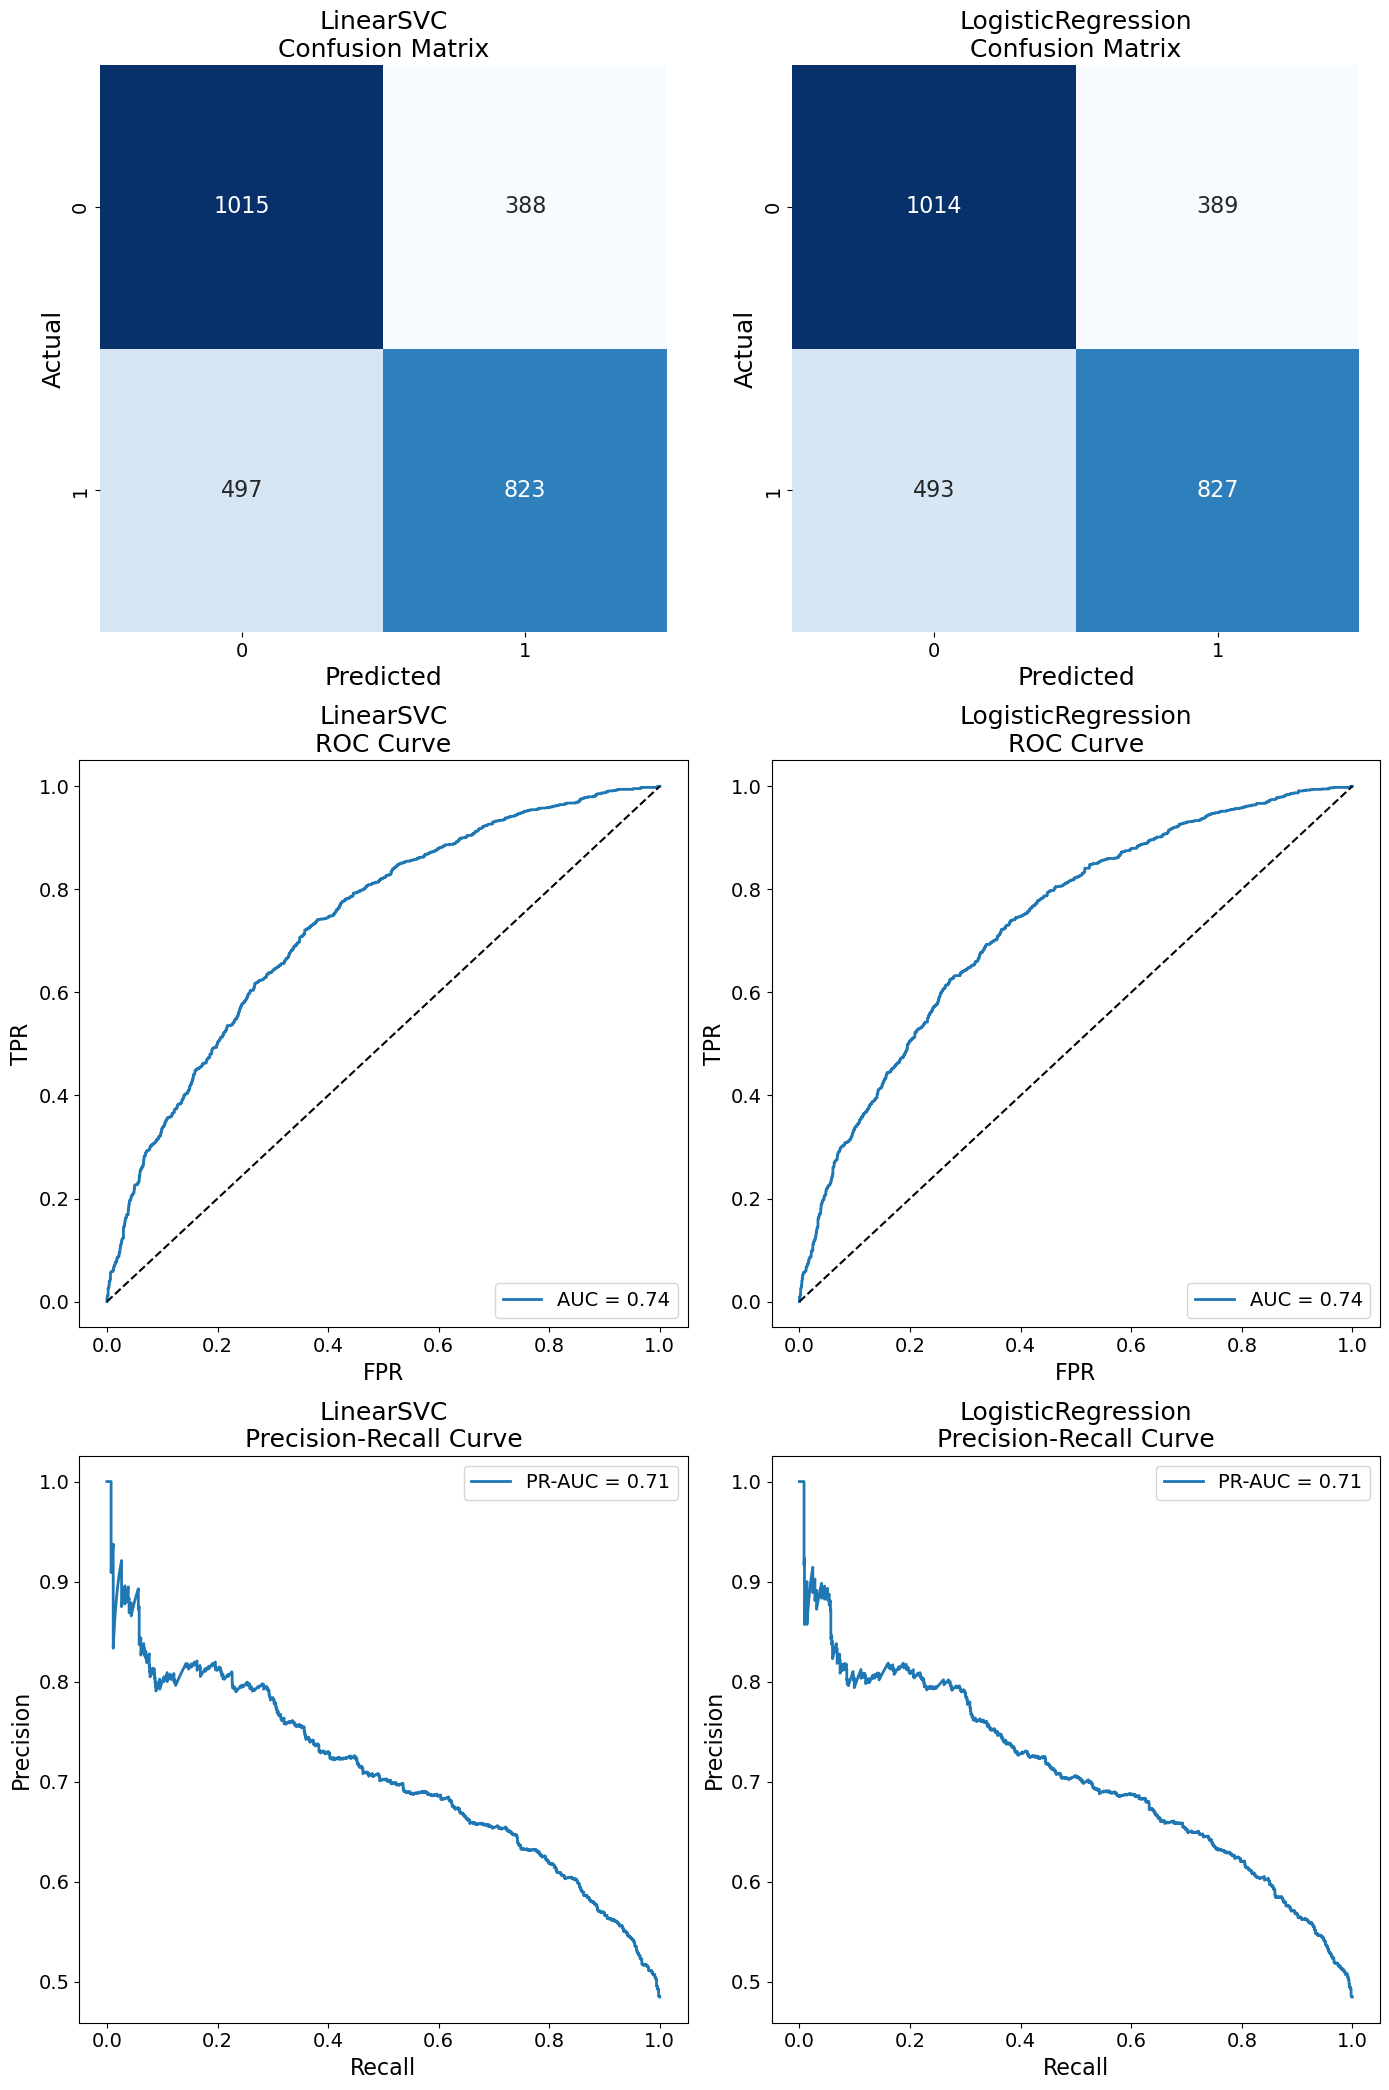

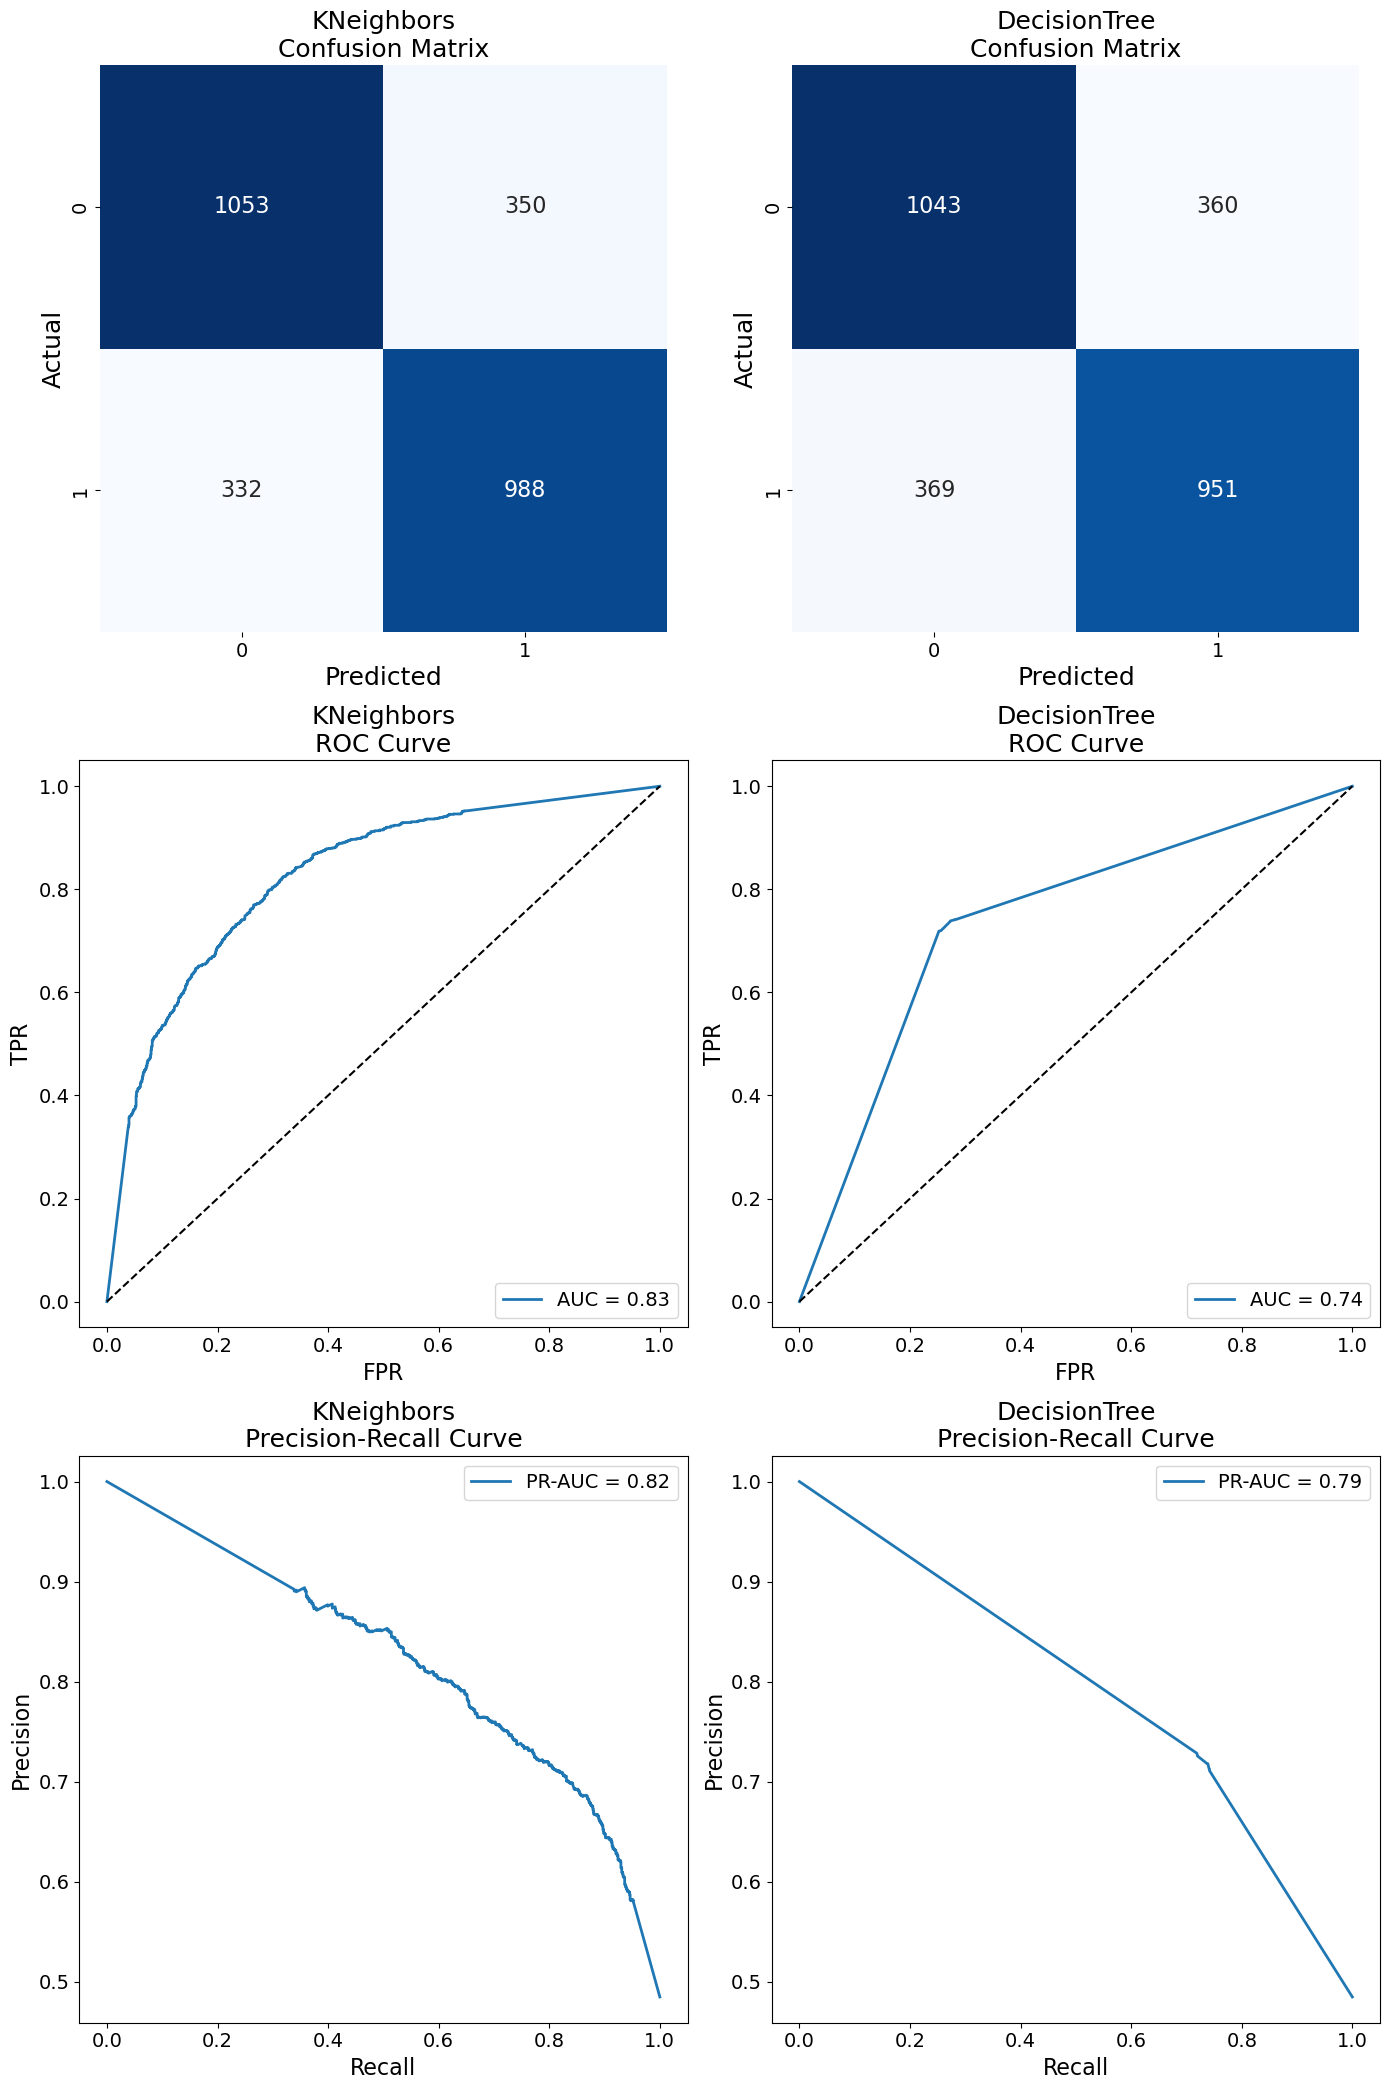

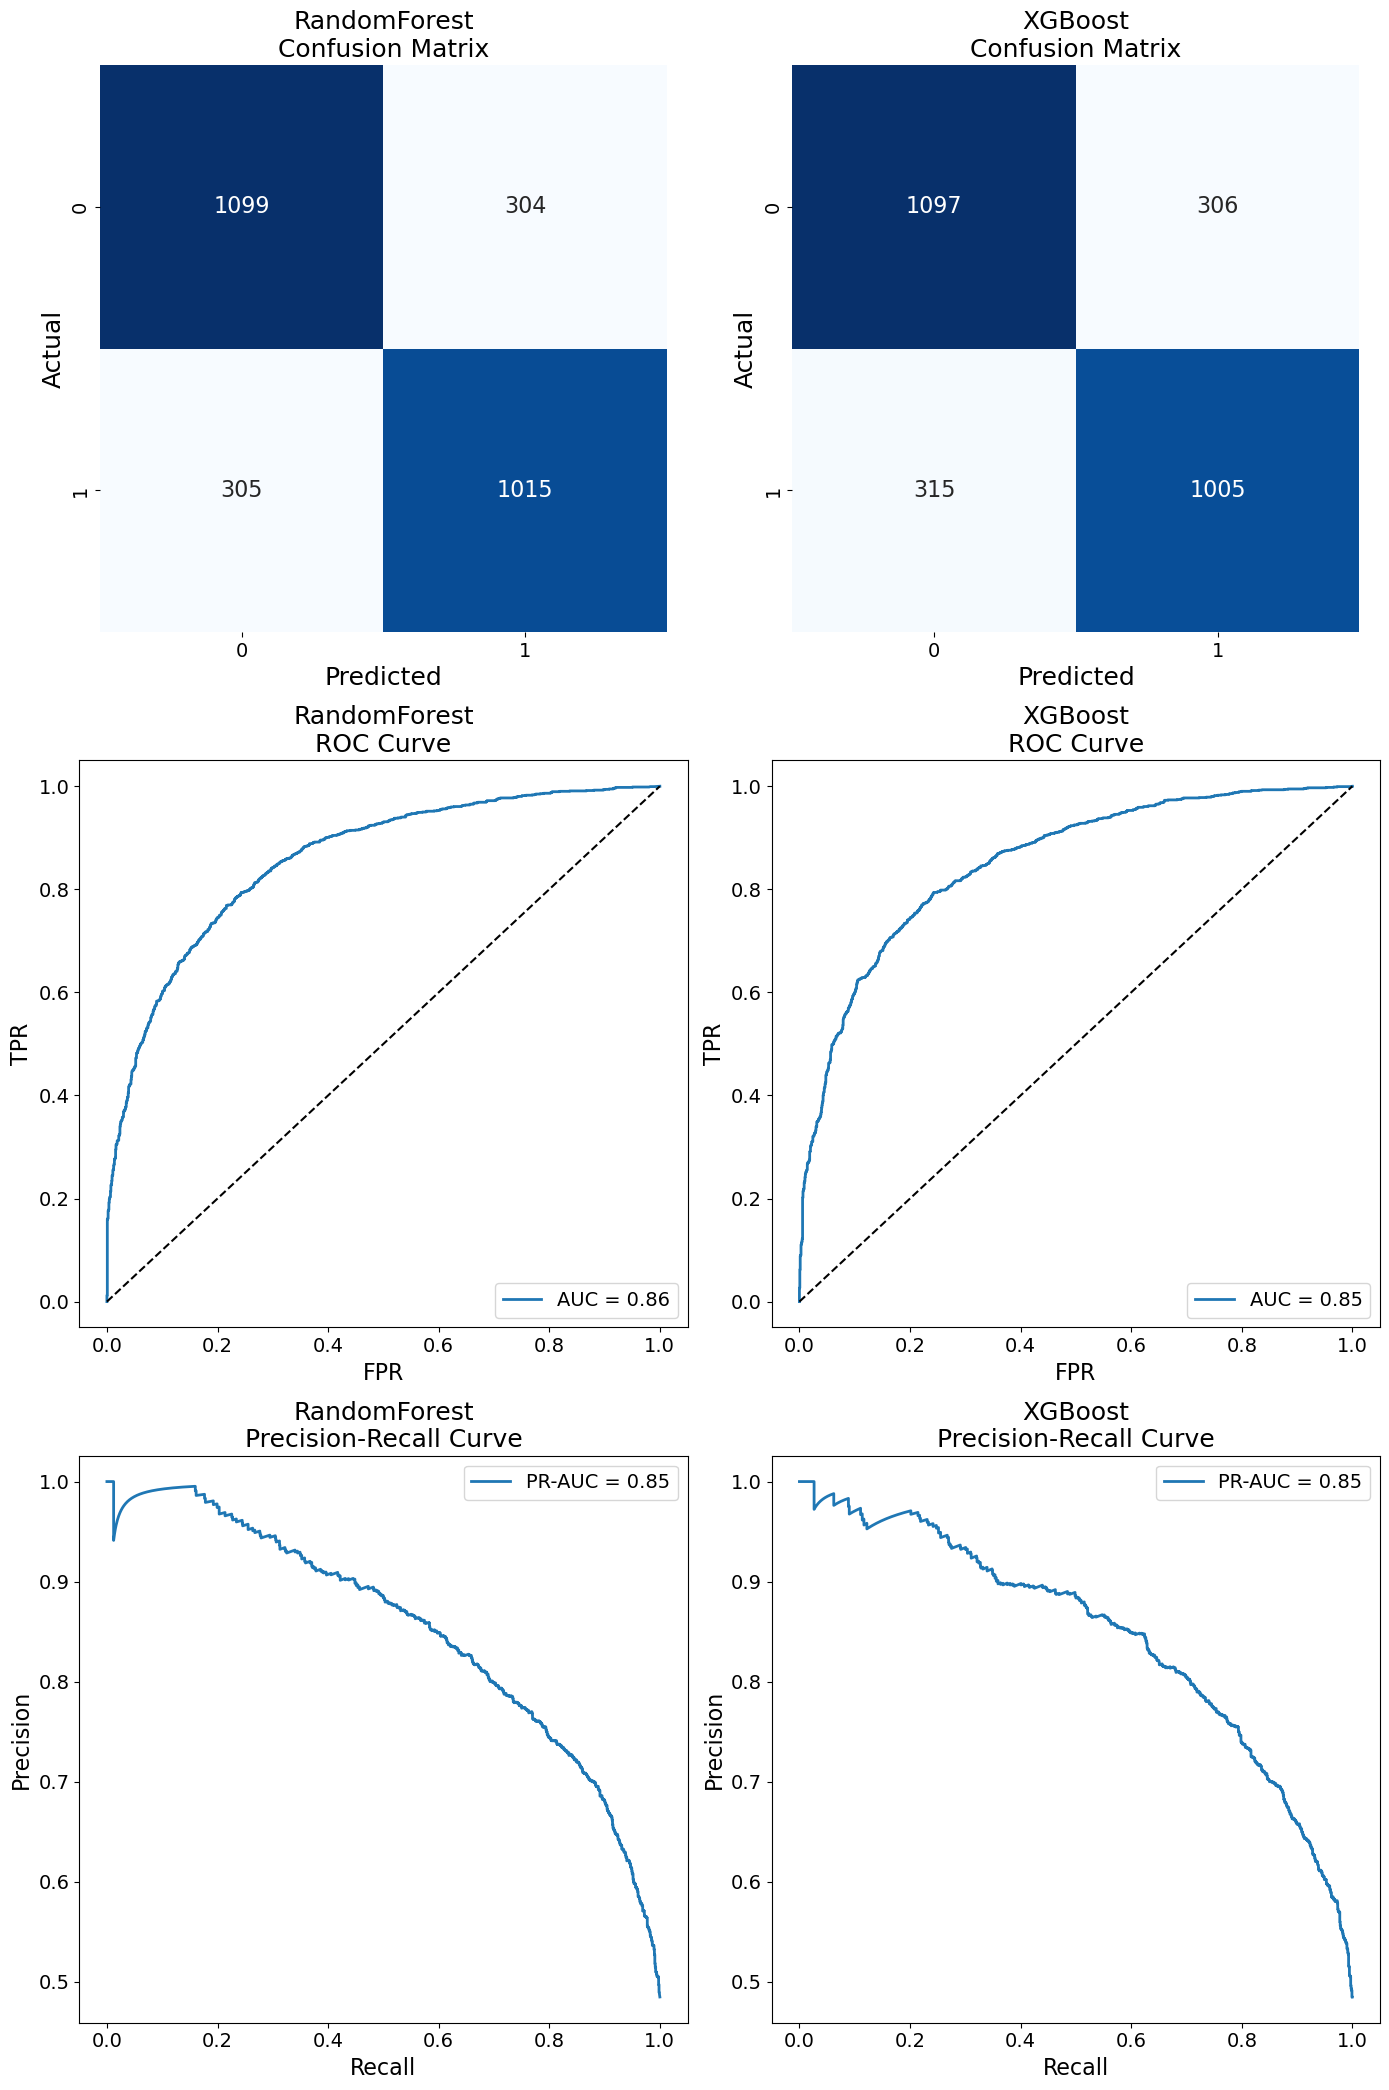

In [17]:

results = []

batch_size = 2
model_batches = [model_names[i:i + batch_size] for i in range(0, len(model_names), batch_size)]

for batch_idx, model_batch in enumerate(model_batches):
    n_models = len(model_batch)
    fig, axs = plt.subplots(3, n_models, figsize=(7 * n_models, 21))

    for i, name in enumerate(model_batch):
        y_pred = preds[name]
        y_prob = probs[name]

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            ax=axs[0, i],
            annot_kws={'size': 16},
            cbar=False,
            square=True
        )
        axs[0, i].set_title(f'{name}\nConfusion Matrix', fontsize=18)
        axs[0, i].set_xlabel('Predicted', fontsize=18)
        axs[0, i].set_ylabel('Actual', fontsize=18)
        axs[0, i].tick_params(axis='both', labelsize=14)
        axs[0, i].set_aspect('equal', adjustable='box')

        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        axs[1, i].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', linewidth=2)
        axs[1, i].plot([0, 1], [0, 1], 'k--')
        axs[1, i].set_title(f'{name}\nROC Curve', fontsize=18)
        axs[1, i].set_xlabel('FPR', fontsize=16)
        axs[1, i].set_ylabel('TPR', fontsize=16)
        axs[1, i].legend(loc='lower right', fontsize=14)
        axs[1, i].tick_params(axis='both', labelsize=14)

        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recall, precision)
        axs[2, i].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}', linewidth=2)
        axs[2, i].set_title(f'{name}\nPrecision-Recall Curve', fontsize=18)
        axs[2, i].set_xlabel('Recall', fontsize=16)
        axs[2, i].set_ylabel('Precision', fontsize=16)
        axs[2, i].legend(fontsize=14)
        axs[2, i].tick_params(axis='both', labelsize=14)

        results.append({
            'Model': name,
            'Accuracy': acc,
            'F1 Score': f1,
            'ROC-AUC': roc_auc,
            'PR-AUC': pr_auc,
            'Precision': prec,
            'Recall': rec,
        })

    plt.tight_layout()
    plt.savefig(f'../images/models_confusion_ROC_PR_batch{batch_idx+1}.png', dpi=300)
    plt.show()

df_results = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
df_results_rounded = df_results.round(3)


In [19]:
df_results_rounded

,Model,Accuracy,F1 Score,ROC-AUC,PR-AUC,Precision,Recall
4,RandomForest,0.776,0.769,0.857,0.854,0.770,0.769
5,XGBoost,0.772,0.764,0.852,0.846,0.767,0.761
2,KNeighbors,0.750,0.743,0.827,0.822,0.738,0.748
3,DecisionTree,0.732,0.723,0.737,0.792,0.725,0.720
1,LogisticRegression,0.676,0.652,0.736,0.707,0.680,0.627
0,LinearSVC,0.675,0.650,0.736,0.707,0.680,0.623


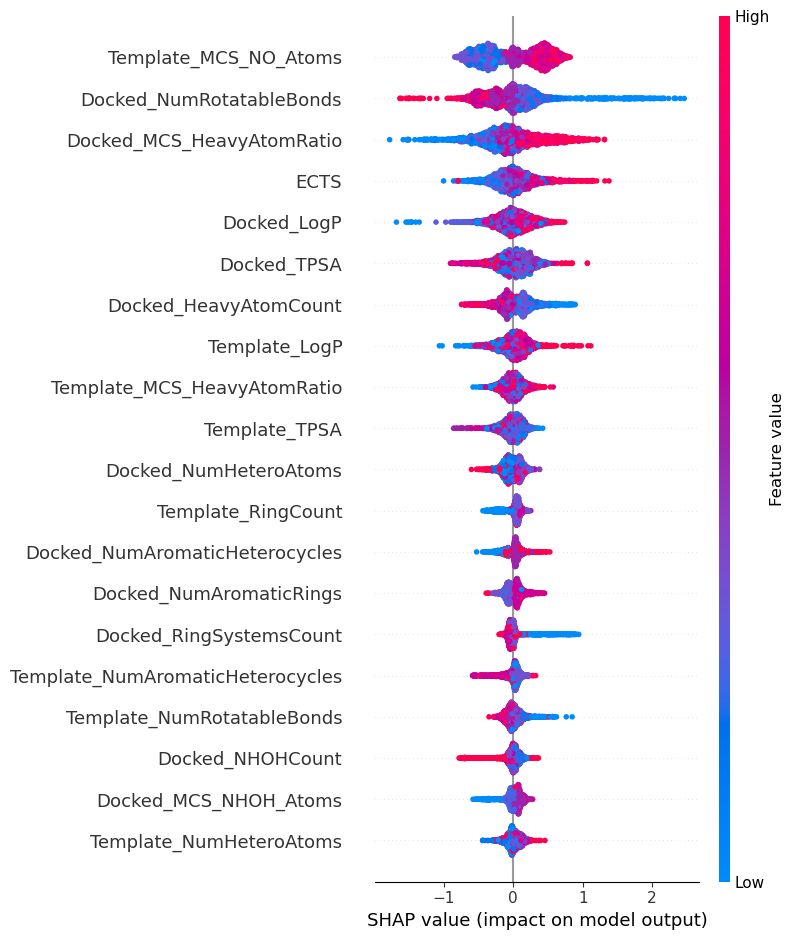

In [20]:
model = best_models['XGBoost']


explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot (beeswarm)
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)



In [32]:
mean_abs_shap = np.abs(shap_values_2.values).mean(axis=0)

# Build DataFrame
importance_df = pd.DataFrame({
    'feature': shap_values.feature_names,
    'mean_abs_shap': mean_abs_shap,
})


# Optional: sort by absolute SHAP
importance_df = importance_df.sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)


# Step 5: Normalize gain for interpretability (optional)
importance_df['mean_abs_shap_normalized'] = importance_df['mean_abs_shap'] / np.sum(importance_df['mean_abs_shap'])

# Step 6: Sort by SHAP importance
importance_df = importance_df.sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)

# Display top features
importance_df

,feature,mean_abs_shap,mean_abs_shap_normalized
0,Template_MCS_NO_Atoms,0.380120,0.099964
1,Docked_NumRotatableBonds,0.323222,0.085001
2,Docked_MCS_HeavyAtomRatio,0.320995,0.084416
3,ECTS,0.205343,0.054001
4,Docked_LogP,0.187102,0.049205
5,Docked_TPSA,0.179567,0.047223
6,Docked_HeavyAtomCount,0.179282,0.047148
7,Template_LogP,0.149517,0.039320
8,Template_MCS_HeavyAtomRatio,0.106028,0.027883
9,Template_TPSA,0.105882,0.027845


In [19]:
importance_df.mean_shap.sum()

np.float32(0.039309118)

In [36]:
importance_df.head(10).mean_abs_shap_normalized.sum()

np.float32(0.5620072)

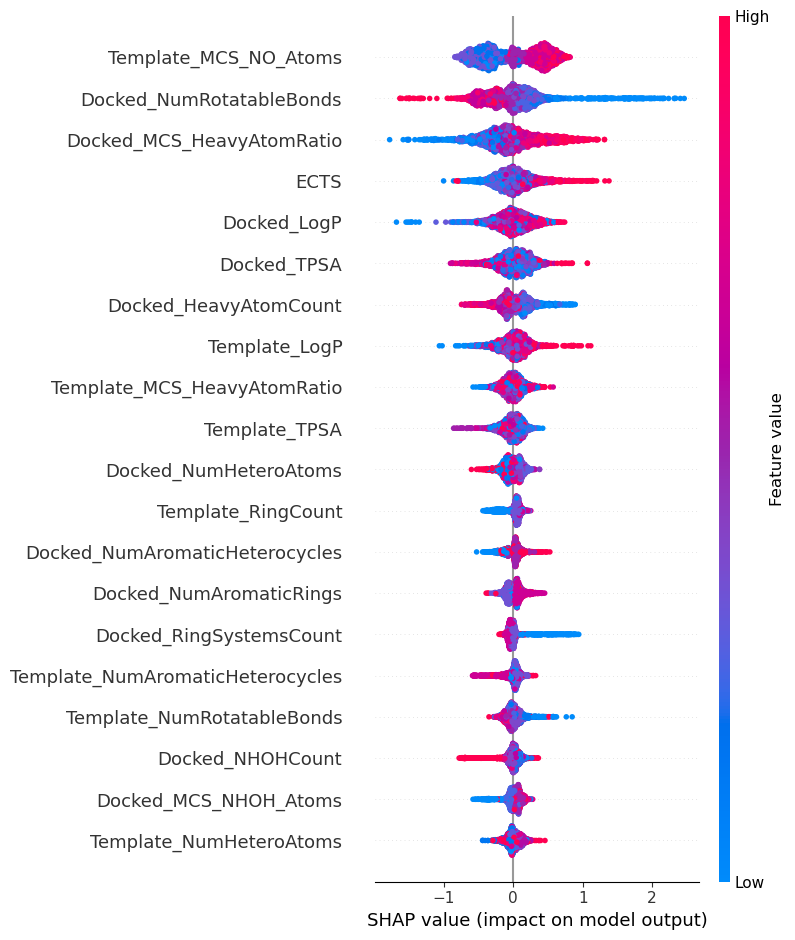

In [27]:
model_2 = best_models['RandomForest']


explainer_2 = shap.Explainer(model_2)
shap_values_2 = explainer(X_test)

# Summary plot (beeswarm)
img_2 = shap.summary_plot(shap_values_2, X_test, feature_names=feature_cols)
img_2

In [31]:
shap.summary_plot(shap_values_2, X_test, feature_names=feature_cols, show=False)

# Grab the current figure from matplotlib
fig = plt.gcf()

# Save the figure
fig.savefig('../images/shap_summary_plot_RF.png', dpi=300, bbox_inches='tight')

# Close the figure to free memory
plt.close(fig)

In [30]:
mean_abs_interactions = np.mean(np.abs(shap_interaction_values), axis=0)  # shape: (n_features, n_features)

features = X_train.columns.tolist()

# Prepare list for DataFrame rows
rows = []
for i, f1 in enumerate(features):
    for j, f2 in enumerate(features):
        rows.append({
            'Feature_1': f1,
            'Feature_2': f2,
            'Mean_Abs_Interaction': mean_abs_interactions[i, j]
        })

interaction_df = pd.DataFrame(rows)

# Optionally, filter out main effects (diagonal)
interaction_df_offdiag = interaction_df[interaction_df['Feature_1'] != interaction_df['Feature_2']]

# Sort descending by interaction strength
interaction_df_offdiag = interaction_df_offdiag.sort_values(by='Mean_Abs_Interaction', ascending=False)

interaction_df_offdiag

,Feature_1,Feature_2,Mean_Abs_Interaction
1317,Docked_MCS_HeavyAtomRatio,Template_MCS_NO_Atoms,0.071056
1203,Template_MCS_NO_Atoms,Docked_MCS_HeavyAtomRatio,0.071056
849,Docked_NumRotatableBonds,Template_MCS_NO_Atoms,0.057569
1191,Template_MCS_NO_Atoms,Docked_NumRotatableBonds,0.057569
1302,Docked_MCS_HeavyAtomRatio,Docked_HeavyAtomCount,0.036253
...,...,...,...
1474,Docked_MCS_H_Donors,Template_MCS_H_Acceptors,0.000000
464,Template_NumAromaticRings,Docked_MCS_NO_Atoms,0.000000
1475,Docked_MCS_H_Donors,Template_MCS_H_Donors,0.000000
1517,ECTS,Docked_MCS_NO_Atoms,0.000000


In [33]:
interaction_df_offdiag['sorted_pair'] = interaction_df_offdiag.apply(
    lambda row: tuple(sorted([row['Feature_1'], row['Feature_2']])), axis=1)

interaction_unique = interaction_df_offdiag.drop_duplicates(subset='sorted_pair').drop(columns='sorted_pair')


interaction_unique.head(30)

,Feature_1,Feature_2,Mean_Abs_Interaction
1317,Docked_MCS_HeavyAtomRatio,Template_MCS_NO_Atoms,0.071056
849,Docked_NumRotatableBonds,Template_MCS_NO_Atoms,0.057569
1302,Docked_MCS_HeavyAtomRatio,Docked_HeavyAtomCount,0.036253
546,Docked_TPSA,Template_TPSA,0.035432
1325,Docked_MCS_HeavyAtomRatio,ECTS,0.032682
1125,Template_MCS_HeavyAtomRatio,Docked_MCS_HeavyAtomRatio,0.032209
1496,ECTS,Docked_TPSA,0.031411
833,Docked_NumRotatableBonds,Docked_TPSA,0.031267
1130,Template_MCS_HeavyAtomRatio,ECTS,0.030590
1301,Docked_MCS_HeavyAtomRatio,Docked_TPSA,0.030314
